In [184]:
# run command:$ jupyter nbconvert --to notebook --inplace --execute main.ipynb

from sklearn.datasets import fetch_openml
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt
from PIL import Image, ImageOps
import numpy as np
import os

In [197]:
# define the scaler
scaler = MinMaxScaler()

# label encoder
label_encoder = LabelEncoder()

# Load MNIST dataset
mnist = fetch_openml('mnist_784')
images = mnist['data']
labels = mnist['target']

# Normalize the data
images_normalized = scaler.fit_transform(images)

# split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(images_normalized, labels, test_size=0.1)

# Print the shape of the dataset
print("(Number of images, Shape of images):", images.shape)
print("(Number of labels):", labels.shape)

(Number of images, Shape of images): (70000, 784)
(Number of labels): (70000,)


In [138]:
# Define the SVM model
svm_classifier = SVC(kernel='rbf', C=10, gamma='scale')

# train the model
svm_classifier.fit(X_train, y_train)

# Evaluate the model
accuracy = svm_classifier.score(X_test, y_test)
print("Accuracy of SVM classifier:", accuracy)


Accuracy of SVM classifier: 0.982


In [142]:
# GBT takes really long to run
# Define the Gradient Boosting model
clf_gbt = GradientBoostingClassifier(
    n_estimators=50,
    learning_rate=0.05,
    max_depth=2,
    min_samples_split=5,
    min_samples_leaf=2,
    subsample=0.8,
    verbose=0,
)

# train the model
clf_gbt.fit(X_train, y_train)

# Evaluate the model
accuracy = clf_gbt.score(X_test, y_test)
print("Accuracy of GBT classifier:", accuracy)

Accuracy of SVM classifier: 0.982


Epoch 1/3
1969/1969 ━━━━━━━━━━━━━━━━━━━━ 27s 13ms/step - accuracy: 0.8950 - loss: 0.3288
Epoch 2/3
1969/1969 ━━━━━━━━━━━━━━━━━━━━ 25s 13ms/step - accuracy: 0.9840 - loss: 0.0502
Epoch 3/3
1969/1969 ━━━━━━━━━━━━━━━━━━━━ 26s 13ms/step - accuracy: 0.9887 - loss: 0.0328
Accuracy of CNN classifier: 0.9874285459518433


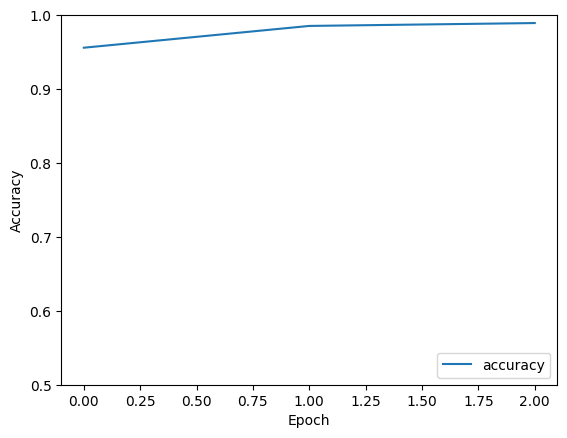

In [198]:
# define the Convolutional Neural Network
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(10))

# Convert labels to integer format for CNN
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

# Reshape data for CNN input, inputs are 28x28 gray scale
X_train_reshaped = X_train.reshape(-1, 28, 28, 1)
X_test_reshaped = X_test.reshape(-1, 28, 28, 1)

# train the model
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

history = model.fit(X_train_reshaped, y_train_encoded, epochs=3)

# Evaluate the model
test_loss, test_acc = model.evaluate(X_test_reshaped,  y_test_encoded, verbose=0)
print("Accuracy of CNN classifier:", test_acc)

# Plot
plt.plot(history.history['accuracy'], label='accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


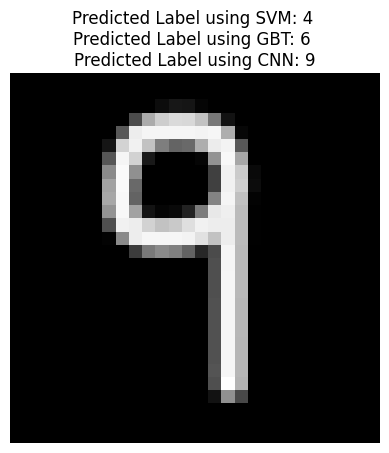

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


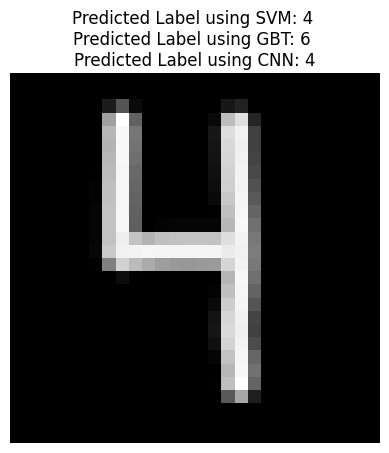

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


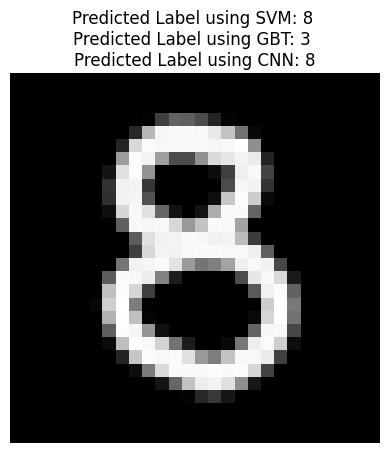

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


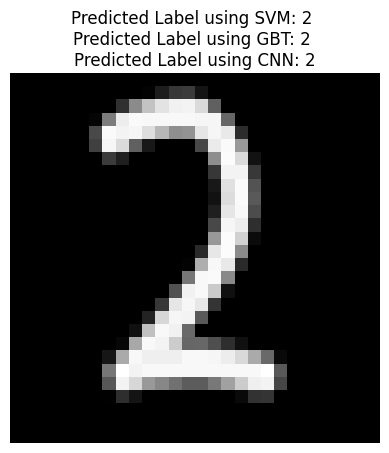

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


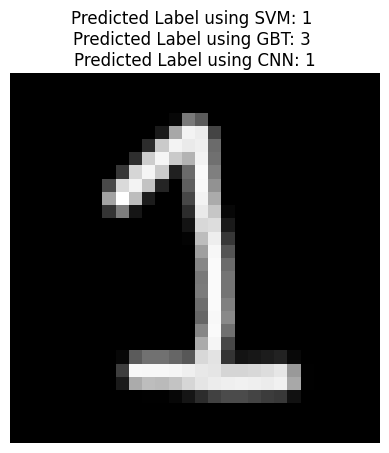

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


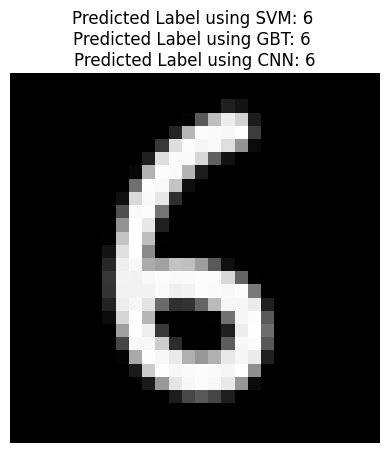

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


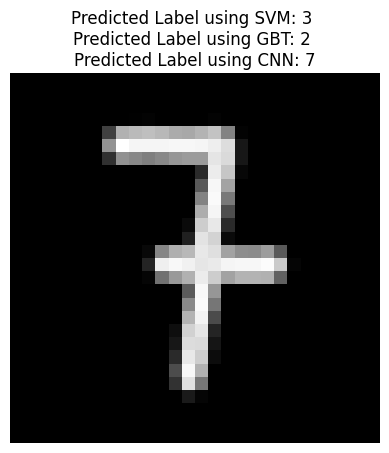

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


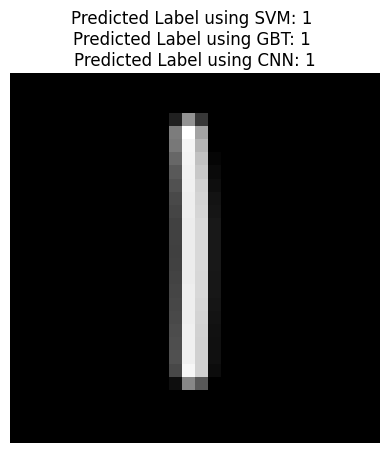

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


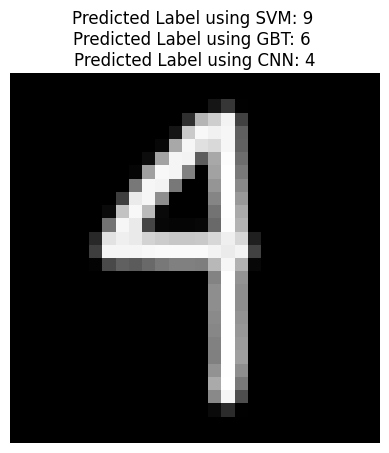

In [205]:
# convert an image I drew to test the model with

# Directory containing images
directory = "images/"

# Iterate through each image in the directory
for filename in os.listdir(directory):
    if filename.endswith(".png"):
        # Load the handwritten image as grayscale
        image = Image.open(os.path.join(directory, filename)).convert("L")

        # Resize the image to 28x28 pixels
        image = image.resize((28, 28))

        # Invert the pixel values
        image = ImageOps.invert(image)

        # Convert the image to a numpy array
        image_array = np.array(image)

        # Flatten the image array
        image_flattened = image_array.flatten()

        # Scale the pixel values to the range [0, 1]
        # this is equivalent to using the MinMaxScaler()
        image_scaled = image_flattened / 255.0

        # Predict the label using the trained models
        predicted_label_svm = svm_classifier.predict([image_scaled])[0]
        predicted_label_gbt = clf_gbt.predict([image_scaled])[0]

        # Predict with CNN
        ni = image_scaled.reshape(-1, 28, 28, 1)
        l = model.predict([ni])[0]
        predicted_label_cnn = np.argmax(l)

        # define an image that can be shown to compare to the prediction
        image_to_show = image_scaled.reshape(28, 28)

        # Display the image along with the predicted labels
        plt.imshow(image_to_show, cmap='gray')
        plt.axis('off')
        plt.title(f'Predicted Label using SVM: {predicted_label_svm} \nPredicted Label using GBT: {predicted_label_gbt} \nPredicted Label using CNN: {predicted_label_cnn}')
        plt.show()
